# Input space analysis

We briefly analyze potential correlations in customers' attribute space. This will help us to define the right set of features to plug into the analysis. We perform the analysis for a small number of campaigns.

1. [Cinema Christmas](#Cinema-Christmas)
2. [Mobile](#Mobile)
3. [TV Winback UK](#TV-Winback-UK)

In [31]:
import numpy as np
import pandas as pd

import logging
import os
import gcsfs
import time
import datetime
import dateutil.relativedelta
from google.cloud import bigquery

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../../variable-clustering/')
sys.path.append('../../../STLP/')
sys.path.append('{}/decisioning-analysis/test_and_learn/production_modules/'.format(os.environ['HOME']))

from varclushi import VarClusHi
from correlation.cramersv import CramersV

from preprocessing_utils.campaign_info_preprocessing import get_campaigns_relevant_info
from preprocessing_utils.campaign_info_preprocessing import create_right_granularity_level
from preprocessing_utils.campaign_info_preprocessing import create_prop_mart_date
from preprocessing_utils.campaign_info_preprocessing import provide_target_flag

from io_utils.input_extraction import pull_table
from preprocessing_utils.input_features_preprocessing import preprocess_data

from analysis_execution.run_ccp_analysis import create_logger

In [2]:
CAMPAIGN_DATA_PATHS = {'project_id':'skyuk-uk-decis-models-01-dev',
                       'dataset_id':'test_and_learn',
                       'table_id':'optimus_base_clean'}
PROP_MART_DATA_PATHS = {'project_id':'skyuk-uk-decis-models-01-dev',
                       'dataset_id':'uk_inp_prodrecs_ic',
                       'table_id':'Propensity_Model_Mart_Training'} 

OPTIMUS_COLS = {'program_label':'L1_programme',
                'campaign_label':'L2_Campaign',
                'journey_label':'L3_Journey',
                'step_label':'L4_Step',
                'variant_label':'L5_variant',
                'product_label':'product',
                'account_number_label':'account_number',
                'sale_vol_label':'sale_vol',
                'sale_aux_vol_label':'sale_auxillary_vol',
                'cell_label':'cell_type',
                'control_label':'control_type2',
                'start_date_label':'CAMPAIGN_REPORTING_START_DATE',
                'channel_label':'CHANNEL'}

PROPMART_FEAT = ['Base_Dt',
                 'account_number',
                 
                 'TAs_in_last_14d',
                 'BB_Curr_Contract_Intended_End_Dt',
                 'DTV_Curr_Contract_Intnd_End_Dt',
                 'Curr_Offer_Intended_end_Dt_DTV',
                 'Curr_Offer_Intended_end_Dt_BB',
                 'BB_Last_Activation_Dt',
                 'DTV_Last_Activation_Dt',
                 
                 'DTV_Active',
                 'BB_Active',
                 'Sports_Active',
                 'Movies_Active',
                 'MS_Active',
                 'SGE_Active',
                 'HD_Active',
                 'Sky_Box_Sets_Active',
                 'UOD_Active',
                 'SkyKids_Active',
                 'Handset_Active',
                 'skyfibre_enabled',
                 
                 'Age',
                 'h_equivalised_income_value',
                 'h_residence_type',
                 'h_number_of_adults',
                 'h_number_of_children_in_hh',
                 'h_presence_of_child_aged_0_4',
                 'h_presence_of_child_aged_5_11',
                 'h_presence_of_child_aged_12_17',
                 
                 'Broadband_Average_Demand',
                 'BT_Consumer_Market_Share',
                 'Sky_Consumer_Market_Share',
                 'Virgin_Consumer_Market_Share',
                 'TalkTalk_Consumer_Market_Share',
                 
                 
                 'Cricket_Sports_Pref',
                 'Football_Sports_Pref',
                 'Rugby_Union_Sports_Pref',
                 'Rugby_League_Sports_Pref',
                 'F1_Sports_Pref',
                 'Darts_Sports_Pref',
                 'Tennis_Sports_Pref',
                 'Racing_Sports_Pref',
                 'Boxing_Sports_Pref',
                 'Golf_Sports_Pref',
                 'NFL_Sports_Pref',
                 'Wrestling_Sports_Pref',
                 'ESports_Sports_Pref',
                 'GAA_Sports_Pref',
                 'Motorsport_Sports_Pref',
                 'Cycling_Sports_Pref',
                 'Netball_Sports_Pref',

                 'Up_Handset',
                 'Up_Mobile ']

BUCKET_ID = 'fci02/test_and_learn'

mapping_dict = {'h_presence_of_child_aged_0_4':{'No':0,'Yes':1},
                'h_presence_of_child_aged_5_11':{'No':0,'Yes':1},
                'h_presence_of_child_aged_12_17':{'No':0,'Yes':1},}

tree_pms = {'n_estimators':[500],
            'min_samples_leaf':[500],
            'max_depth':[ 5],
            'max_allowed_depth':5,
            'min_allowed_node_size':5000,
            'n_best_features':3,
            'njobs':14}

control_name_dict = {'skyOptimusGetMore':'Campaign control','skyOptimusDMO':'Fallow Group'}

PROJECT_ID_1 = 'skyuk-uk-decis-models-01-dev'
DATASET_ID_1 = 'test_and_learn'
BUCKET_ID = 'fci02/test_and_learn'
CAMPAING_TABLE_NAME = 'optimus_base_clean'

granularity_level = 'overall'

base_date_label='Base_Dt'
default_treat_table_name='Campaign_treat_tmp'
control_name_dict = {'skyOptimusGetMore':'Campaign control','skyOptimusDMO':'Fallow Group'}

to_exclude = ['Base_Dt', 'account_number','L2_Campaign','target']

In [3]:
campaigns_list = get_campaigns_relevant_info(PROJECT_ID_1,DATASET_ID_1,CAMPAING_TABLE_NAME,
                                             OPTIMUS_COLS['program_label'],
                                             OPTIMUS_COLS['campaign_label'],
                                             OPTIMUS_COLS['start_date_label'], 
                                             OPTIMUS_COLS['product_label'],
                                             OPTIMUS_COLS['journey_label'],
                                             OPTIMUS_COLS['step_label'],
                                             OPTIMUS_COLS['variant_label']
                                            )
campaigns_list.head(10)

,campaign_program,campaign_name,start_date,journey,step,variant,product,channel
0,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM1_3127-4_(DM241975)_...,TV Winback,EM&DM
1,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
2,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
3,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
4,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
5,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
6,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
7,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_DECEMBER_EM8-2737-18_(DM231961...,TV Winback,EM&DM
8,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_DECEMBER_EM8-2737-18_(DM231961...,TV Winback,EM&DM
9,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_DECEMBER_EM8-2737-18_(DM231961...,TV Winback,EM&DM


## Cinema Christmas

In [4]:
to_analyze = campaigns_list[['campaign_program','campaign_name']].drop_duplicates()
idx=to_analyze[to_analyze.campaign_name=='Cinema Christmas'].index
to_analyze.loc[idx,['campaign_program','campaign_name']]

,campaign_program,campaign_name
17408,skyOptimusGetMore,Cinema Christmas


In [5]:
granularity_level_table,analysis_level = create_right_granularity_level(campaigns_list,to_analyze.loc[idx,['campaign_program','campaign_name']], granularity_level)
prop_mart_date = create_prop_mart_date(granularity_level_table)
granularity_level_table
subset_row = granularity_level_table.loc[0,:]
target_var_list = provide_target_flag(subset_row)

In [6]:
test_table = pull_table(CAMPAIGN_DATA_PATHS, PROP_MART_DATA_PATHS, subset_row,target_var_list,analysis_level,
                        OPTIMUS_COLS, PROPMART_FEAT,
                        base_date_label, prop_mart_date,subset_row['start_date'],
                        '=', control_name_dict[subset_row['campaign_program']], subset_row['product'],default_treat_table_name,
                        BUCKET_ID)

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


In [7]:
test_table.head()

,Base_Dt,account_number,TAs_in_last_14d,BB_Curr_Contract_Intended_End_Dt,DTV_Curr_Contract_Intnd_End_Dt,Curr_Offer_Intended_end_Dt_DTV,Curr_Offer_Intended_end_Dt_BB,BB_Last_Activation_Dt,DTV_Last_Activation_Dt,DTV_Active,...,ESports_Sports_Pref,GAA_Sports_Pref,Motorsport_Sports_Pref,Cycling_Sports_Pref,Netball_Sports_Pref,Up_Handset,Up_Mobile,L2_Campaign,ncomms,target
0,2018-11-30,622019172692,0,NaN,2019-08-08,NaN,NaN,2015-09-15,2015-08-25,1,...,0,0,0,0,0,0,0,Cinema Christmas,0,0
1,2018-11-30,623135519899,0,NaN,2019-04-23,2019-04-23,NaN,NaN,2017-10-23,1,...,0,0,0,0,0,0,0,Cinema Christmas,0,0
2,2018-11-30,621695124761,0,NaN,NaN,NaN,NaN,2012-12-14,2012-01-17,1,...,0,0,0,0,0,0,0,Cinema Christmas,0,0
3,2018-11-30,621255537733,0,NaN,2019-01-27,NaN,NaN,NaN,2016-05-28,1,...,0,0,0,0,0,0,0,Cinema Christmas,0,0
4,2018-11-30,430049765729,0,NaN,2019-03-29,2019-04-21,NaN,NaN,2016-09-21,1,...,0,0,0,0,0,0,0,Cinema Christmas,0,0


In [8]:
test_table.shape

(1040362, 56)

In [9]:
logger = create_logger()
_ = preprocess_data(test_table,mapping_dict,to_exclude,logger=logger)

08-Nov-19 10:22:32 - #################### DATA PREPROCESSING ####################
08-Nov-19 10:22:32 - 1) Removing features with high percentage of nulls
08-Nov-19 10:22:33 - 1a) Setting boolean input features to integers
08-Nov-19 10:22:33 - 1b) Removing constant features
08-Nov-19 10:22:38 - Removing ['Sky_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'ncomms']
08-Nov-19 10:22:38 - 2) Features engineering
08-Nov-19 10:22:38 - 2a) Mappings
08-Nov-19 10:22:39 - 2b) Rounding income value
08-Nov-19 10:22:40 - 2c) Creating contract/offer status features
08-Nov-19 10:23:15 - 2d) Creating number of days of tenure
08-Nov-19 10:23:36 -      Number of rows lost: 164716
08-Nov-19 10:23:36 -      % of rows lost: 15.83%
08-Nov-19 10:23:36 - Data preprocessed in 63.144 seconds


In [10]:
test_table.shape

(875646, 51)

In [18]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [20]:
numeric = test_table.drop(columns=to_exclude)._get_numeric_data().columns
for column in numeric:
    if is_binary(test_table[column], allow_na=False):
        print(column)

DTV_Active
BB_Active
Sports_Active
Movies_Active
MS_Active
SGE_Active
HD_Active
Sky_Box_Sets_Active
UOD_Active
SkyKids_Active
Handset_Active
h_presence_of_child_aged_0_4
h_presence_of_child_aged_5_11
h_presence_of_child_aged_12_17
BT_Consumer_Market_Share
Darts_Sports_Pref
Racing_Sports_Pref
NFL_Sports_Pref
ESports_Sports_Pref
Motorsport_Sports_Pref
Cycling_Sports_Pref
Netball_Sports_Pref
Up_Handset
Up_Mobile


In [26]:
binary = ['DTV_Active', 'BB_Active', 'Sports_Active', 'Movies_Active', 'MS_Active' ,'SGE_Active', 'HD_Active', 'Sky_Box_Sets_Active', 'UOD_Active', 'SkyKids_Active',
          'Handset_Active', 'h_presence_of_child_aged_0_4', 'h_presence_of_child_aged_5_11', 'h_presence_of_child_aged_12_17', 'Up_Handset', 'Up_Mobile']

In [27]:
real_numeric = [feature for feature in numeric if feature not in binary]

In [28]:
analyzer = VarClusHi(test_table[real_numeric],maxeigval2=1,maxclus=None)

In [29]:
analyzer.varclus()

In [30]:
analyzer.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,F1_Sports_Pref,0.205620,0.029262,0.818326
1,0,Darts_Sports_Pref,0.228863,0.011074,0.779773
2,0,Tennis_Sports_Pref,0.443839,0.049561,0.585162
3,0,Boxing_Sports_Pref,0.420269,0.034460,0.600422
4,0,Golf_Sports_Pref,0.320293,0.036740,0.705631
5,0,Wrestling_Sports_Pref,0.269939,0.015293,0.741399
6,1,ESports_Sports_Pref,0.571169,0.035085,0.444424
7,1,Motorsport_Sports_Pref,0.321615,0.021856,0.693542
8,1,Netball_Sports_Pref,0.571169,0.035085,0.444424
9,2,Age,0.565492,0.016670,0.441874


Cluster 2 and 4 are the really interesting ones

In [37]:
test_table[['Age','h_number_of_adults','tenure_months']].corr()

,Age,h_number_of_adults,tenure_months
Age,1.000000,0.118217,0.231000
h_number_of_adults,0.118217,1.000000,0.070081
tenure_months,0.231000,0.070081,1.000000


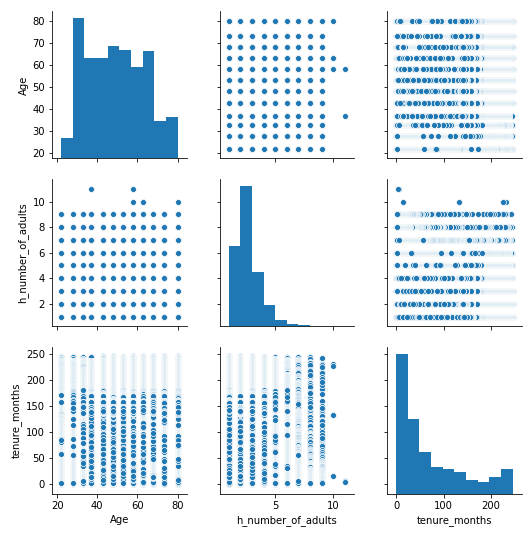

In [39]:
sns.pairplot(test_table[['Age','h_number_of_adults','tenure_months']])
plt.show()

In [38]:
test_table[['h_equivalised_income_value','h_number_of_children_in_hh']].corr()

,h_equivalised_income_value,h_number_of_children_in_hh
h_equivalised_income_value,1.000000,-0.163573
h_number_of_children_in_hh,-0.163573,1.000000


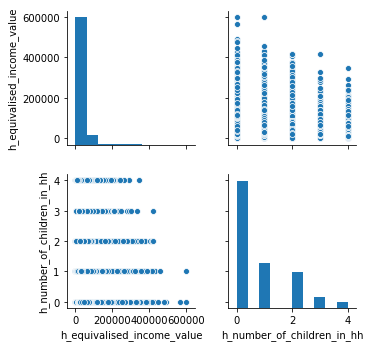

In [41]:
sns.pairplot(test_table[['h_equivalised_income_value','h_number_of_children_in_hh']])
plt.show()

In [43]:
categorical = [column for column in test_table.drop(columns=to_exclude).columns if column not in real_numeric]
categorical

['DTV_Active',
 'BB_Active',
 'Sports_Active',
 'Movies_Active',
 'MS_Active',
 'SGE_Active',
 'HD_Active',
 'Sky_Box_Sets_Active',
 'UOD_Active',
 'SkyKids_Active',
 'Handset_Active',
 'skyfibre_enabled',
 'h_residence_type',
 'h_presence_of_child_aged_0_4',
 'h_presence_of_child_aged_5_11',
 'h_presence_of_child_aged_12_17',
 'Up_Handset',
 'Up_Mobile',
 'BB_contract_status',
 'DTV_contract_status',
 'DTV_offer_status',
 'BB_offer_status']

In [44]:
cramer_analyzer = CramersV(test_table[categorical])

In [45]:
cramer_table=cramer_analyzer.produce_correlation_table()

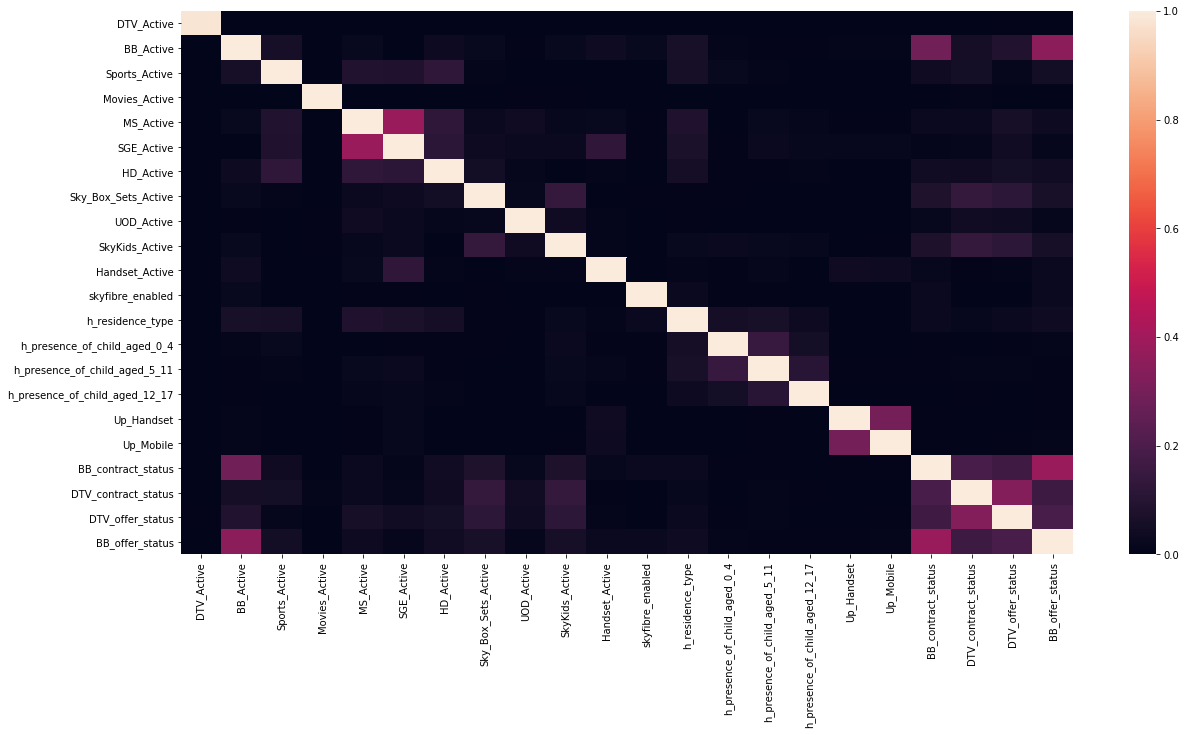

In [46]:
plt.figure(figsize=(20,10))
cramer_analyzer.produce_heatmap(cramer_table)

## Mobile

In [47]:
to_analyze = campaigns_list[['campaign_program','campaign_name']].drop_duplicates()
idx=to_analyze[to_analyze.campaign_name=='Mobile'].index
to_analyze.loc[idx,['campaign_program','campaign_name']]

,campaign_program,campaign_name
13872,skyOptimusGetMore,Mobile


In [48]:
granularity_level_table,analysis_level = create_right_granularity_level(campaigns_list,to_analyze.loc[idx,['campaign_program','campaign_name']], granularity_level)
prop_mart_date = create_prop_mart_date(granularity_level_table)
granularity_level_table
subset_row = granularity_level_table.loc[0,:]
target_var_list = provide_target_flag(subset_row)

In [49]:
test_table = pull_table(CAMPAIGN_DATA_PATHS, PROP_MART_DATA_PATHS, subset_row,target_var_list,analysis_level,
                        OPTIMUS_COLS, PROPMART_FEAT,
                        base_date_label, prop_mart_date,subset_row['start_date'],
                        '=', control_name_dict[subset_row['campaign_program']], subset_row['product'],default_treat_table_name,
                        BUCKET_ID)

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


In [50]:
test_table.head()

,Base_Dt,account_number,TAs_in_last_14d,BB_Curr_Contract_Intended_End_Dt,DTV_Curr_Contract_Intnd_End_Dt,Curr_Offer_Intended_end_Dt_DTV,Curr_Offer_Intended_end_Dt_BB,BB_Last_Activation_Dt,DTV_Last_Activation_Dt,DTV_Active,...,ESports_Sports_Pref,GAA_Sports_Pref,Motorsport_Sports_Pref,Cycling_Sports_Pref,Netball_Sports_Pref,Up_Handset,Up_Mobile,L2_Campaign,ncomms,target
0,2018-10-31,622679797333,0,2019-06-28,2019-06-07,2018-12-18,2019-07-18,2017-12-06,2016-05-18,1,...,0,0,0,0,0,0,0,Mobile,0,0
1,2018-10-31,621805104778,0,2019-05-23,2019-05-09,2019-05-09,2019-05-23,2017-11-23,2012-07-05,1,...,0,0,0,0,0,0,0,Mobile,0,0
2,2018-10-31,621573107490,0,NaN,NaN,2019-10-10,2019-07-10,2017-06-23,2014-11-26,1,...,0,0,0,0,0,0,0,Mobile,0,0
3,2018-10-31,210123334539,0,NaN,NaN,2018-12-28,2018-12-28,2012-11-27,2009-03-25,1,...,0,0,0,0,0,0,0,Mobile,0,0
4,2018-10-31,630215276936,0,2018-11-11,2018-12-01,2018-12-01,2018-12-01,2017-05-11,2017-06-01,1,...,0,0,0,0,0,0,0,Mobile,0,0


In [51]:
test_table.shape

(2552877, 56)

In [52]:
logger = create_logger()
_ = preprocess_data(test_table,mapping_dict,to_exclude,logger=logger)

08-Nov-19 11:44:42 - #################### DATA PREPROCESSING ####################
08-Nov-19 11:44:42 - 1) Removing features with high percentage of nulls
08-Nov-19 11:44:44 - 1a) Setting boolean input features to integers
08-Nov-19 11:44:45 - 1b) Removing constant features
08-Nov-19 11:44:57 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'ncomms']
08-Nov-19 11:44:58 - 2) Features engineering
08-Nov-19 11:44:58 - 2a) Mappings
08-Nov-19 11:44:59 - 2b) Rounding income value
08-Nov-19 11:45:01 - 2c) Creating contract/offer status features
08-Nov-19 11:46:29 - 2d) Creating number of days of tenure
08-Nov-19 11:47:26 -      Number of rows lost: 174112
08-Nov-19 11:47:26 -      % of rows lost: 6.82%
08-Nov-19 11:47:26 - Data preprocessed in 164.156 seconds


In [53]:
test_table.shape

(2378765, 50)

In [54]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [55]:
numeric = test_table.drop(columns=to_exclude)._get_numeric_data().columns
for column in numeric:
    if is_binary(test_table[column], allow_na=False):
        print(column)

DTV_Active
BB_Active
Sports_Active
Movies_Active
MS_Active
SGE_Active
HD_Active
Sky_Box_Sets_Active
SkyKids_Active
Handset_Active
h_presence_of_child_aged_0_4
h_presence_of_child_aged_5_11
h_presence_of_child_aged_12_17
BT_Consumer_Market_Share
Darts_Sports_Pref
Tennis_Sports_Pref
Racing_Sports_Pref
Golf_Sports_Pref
NFL_Sports_Pref
ESports_Sports_Pref
GAA_Sports_Pref
Motorsport_Sports_Pref
Cycling_Sports_Pref
Netball_Sports_Pref
Up_Handset
Up_Mobile


In [56]:
binary = ['DTV_Active', 'BB_Active', 'Sports_Active', 'Movies_Active', 'MS_Active' ,'SGE_Active', 'HD_Active', 'Sky_Box_Sets_Active', 'UOD_Active', 'SkyKids_Active',
          'Handset_Active', 'h_presence_of_child_aged_0_4', 'h_presence_of_child_aged_5_11', 'h_presence_of_child_aged_12_17', 'Up_Handset', 'Up_Mobile']

In [57]:
real_numeric = [feature for feature in numeric if feature not in binary]

In [58]:
analyzer = VarClusHi(test_table[real_numeric],maxeigval2=1,maxclus=None)

In [59]:
analyzer.varclus()

In [60]:
analyzer.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Darts_Sports_Pref,0.415586,0.043755,0.611155
1,0,Tennis_Sports_Pref,0.320796,0.018965,0.692335
2,0,Boxing_Sports_Pref,0.422411,0.052220,0.609412
3,0,Golf_Sports_Pref,0.344190,0.031534,0.677164
4,0,Wrestling_Sports_Pref,0.171010,0.008169,0.835819
5,1,Age,0.623300,0.023538,0.385780
6,1,h_number_of_adults,0.165128,0.001974,0.836524
7,1,tenure_months,0.603418,0.000358,0.396724
8,2,Cricket_Sports_Pref,0.520186,0.015002,0.487121
9,2,Football_Sports_Pref,0.174662,0.006066,0.830375


Cluster 2 and 4 are the really interesting ones

In [61]:
test_table[['Age','h_number_of_adults','tenure_months']].corr()

,Age,h_number_of_adults,tenure_months
Age,1.000000,0.112985,0.339144
h_number_of_adults,0.112985,1.000000,0.090151
tenure_months,0.339144,0.090151,1.000000


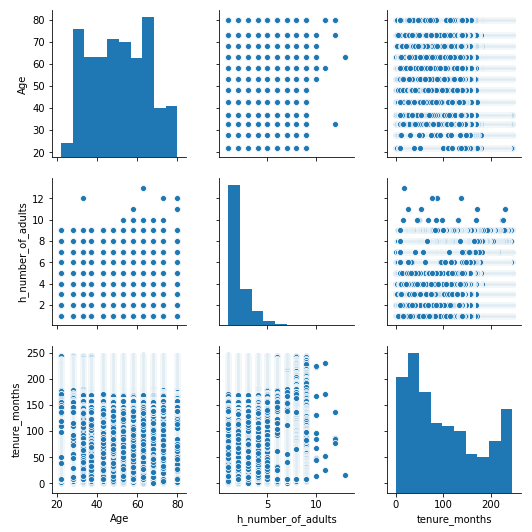

In [62]:
sns.pairplot(test_table[['Age','h_number_of_adults','tenure_months']])
plt.show()

In [63]:
test_table[['h_equivalised_income_value','h_number_of_children_in_hh']].corr()

,h_equivalised_income_value,h_number_of_children_in_hh
h_equivalised_income_value,1.000000,-0.165849
h_number_of_children_in_hh,-0.165849,1.000000


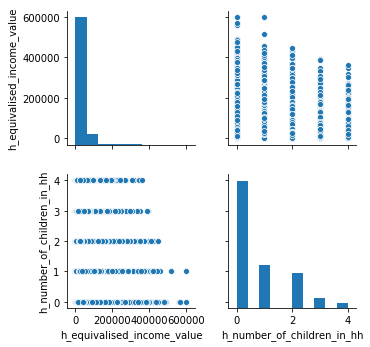

In [64]:
sns.pairplot(test_table[['h_equivalised_income_value','h_number_of_children_in_hh']])
plt.show()

In [65]:
categorical = [column for column in test_table.drop(columns=to_exclude).columns if column not in real_numeric]
categorical

['DTV_Active',
 'BB_Active',
 'Sports_Active',
 'Movies_Active',
 'MS_Active',
 'SGE_Active',
 'HD_Active',
 'Sky_Box_Sets_Active',
 'SkyKids_Active',
 'Handset_Active',
 'skyfibre_enabled',
 'h_residence_type',
 'h_presence_of_child_aged_0_4',
 'h_presence_of_child_aged_5_11',
 'h_presence_of_child_aged_12_17',
 'Up_Handset',
 'Up_Mobile',
 'BB_contract_status',
 'DTV_contract_status',
 'DTV_offer_status',
 'BB_offer_status']

In [66]:
cramer_analyzer = CramersV(test_table[categorical])

In [67]:
cramer_table=cramer_analyzer.produce_correlation_table()

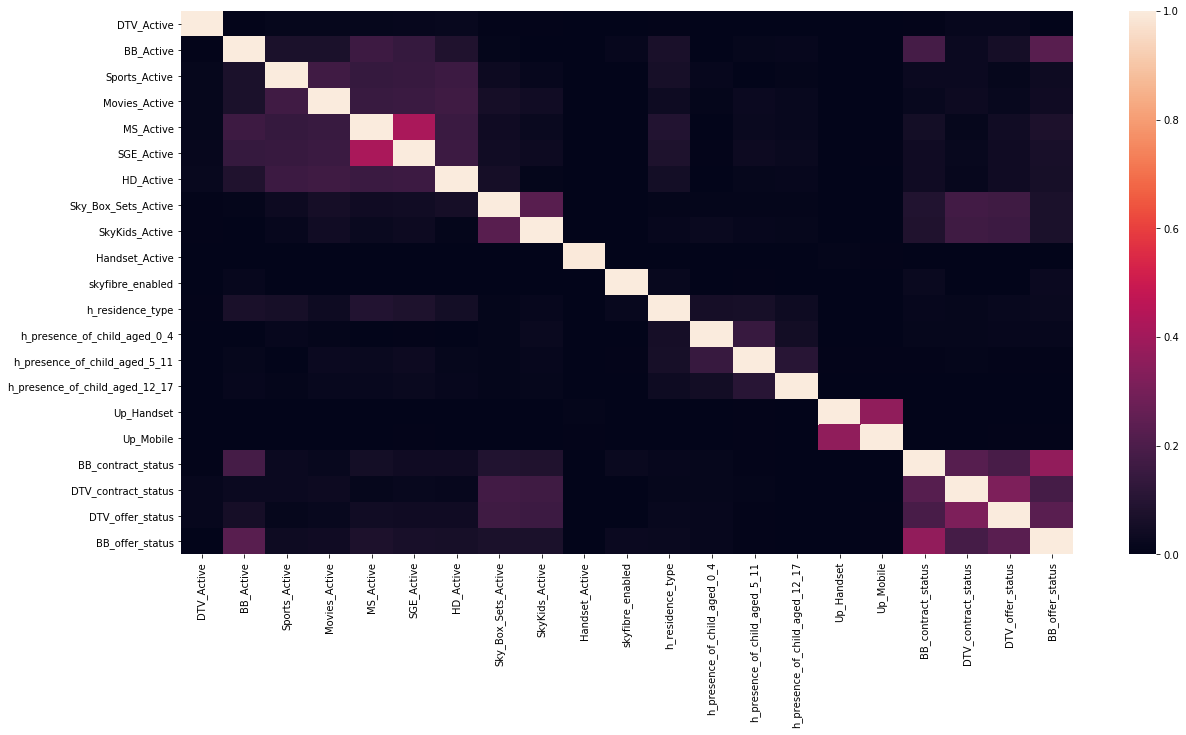

In [68]:
plt.figure(figsize=(20,10))
cramer_analyzer.produce_heatmap(cramer_table)

## TV Winback UK

In [72]:
to_analyze = campaigns_list[['campaign_program','campaign_name']].drop_duplicates()
idx=to_analyze[to_analyze.campaign_name=='Winback DTV UK'].index
to_analyze.loc[idx,['campaign_program','campaign_name']]

,campaign_program,campaign_name
0,skyOptimusDMO,Winback DTV UK


In [73]:
granularity_level_table,analysis_level = create_right_granularity_level(campaigns_list,to_analyze.loc[idx,['campaign_program','campaign_name']], granularity_level)
prop_mart_date = create_prop_mart_date(granularity_level_table)
granularity_level_table
subset_row = granularity_level_table.loc[0,:]
target_var_list = provide_target_flag(subset_row)

In [74]:
test_table = pull_table(CAMPAIGN_DATA_PATHS, PROP_MART_DATA_PATHS, subset_row,target_var_list,analysis_level,
                        OPTIMUS_COLS, PROPMART_FEAT,
                        base_date_label, prop_mart_date,subset_row['start_date'],
                        '=', control_name_dict[subset_row['campaign_program']], subset_row['product'],default_treat_table_name,
                        BUCKET_ID)

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


In [75]:
test_table.head()

,Base_Dt,account_number,TAs_in_last_14d,BB_Curr_Contract_Intended_End_Dt,DTV_Curr_Contract_Intnd_End_Dt,Curr_Offer_Intended_end_Dt_DTV,Curr_Offer_Intended_end_Dt_BB,BB_Last_Activation_Dt,DTV_Last_Activation_Dt,DTV_Active,...,ESports_Sports_Pref,GAA_Sports_Pref,Motorsport_Sports_Pref,Cycling_Sports_Pref,Netball_Sports_Pref,Up_Handset,Up_Mobile,L2_Campaign,ncomms,target
0,2018-09-30,622524397990,0,NaN,NaN,NaN,NaN,2015-10-01,2015-10-16,1,...,0,0,0,0,0,0,0,Winback DTV UK,0,0
1,2018-09-30,210172539475,0,2019-09-14,NaN,NaN,2019-09-14,2018-09-10,2005-06-01,0,...,0,0,0,0,0,0,0,Winback DTV UK,0,0
2,2018-09-30,630091523054,0,NaN,NaN,NaN,NaN,NaN,2010-12-16,1,...,0,0,0,0,0,0,0,Winback DTV UK,0,0
3,2018-09-30,622847624609,0,NaN,2019-09-29,2019-09-29,2019-04-14,2018-04-13,2016-09-24,1,...,0,0,0,0,0,0,0,Winback DTV UK,0,0
4,2018-09-30,621735802517,0,NaN,NaN,NaN,NaN,2012-06-22,2012-04-26,1,...,0,0,0,0,0,0,0,Winback DTV UK,0,0


In [76]:
test_table.shape

(416674, 56)

In [77]:
logger = create_logger()
_ = preprocess_data(test_table,mapping_dict,to_exclude,logger=logger)

08-Nov-19 12:06:50 - #################### DATA PREPROCESSING ####################
08-Nov-19 12:06:50 - 1) Removing features with high percentage of nulls
08-Nov-19 12:06:50 - 1a) Setting boolean input features to integers
08-Nov-19 12:06:50 - 1b) Removing constant features
08-Nov-19 12:06:52 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'ncomms']
08-Nov-19 12:06:52 - 2) Features engineering
08-Nov-19 12:06:52 - 2a) Mappings
08-Nov-19 12:06:52 - 2b) Rounding income value
08-Nov-19 12:06:53 - 2c) Creating contract/offer status features
08-Nov-19 12:07:06 - 2d) Creating number of days of tenure
08-Nov-19 12:07:14 -      Number of rows lost: 41975
08-Nov-19 12:07:14 -      % of rows lost: 10.07%
08-Nov-19 12:07:14 - Data preprocessed in 24.635 seconds


In [78]:
test_table.shape

(374699, 50)

In [79]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [80]:
numeric = test_table.drop(columns=to_exclude)._get_numeric_data().columns
for column in numeric:
    if is_binary(test_table[column], allow_na=False):
        print(column)

DTV_Active
BB_Active
Sports_Active
Movies_Active
MS_Active
SGE_Active
HD_Active
Sky_Box_Sets_Active
SkyKids_Active
Handset_Active
h_presence_of_child_aged_0_4
h_presence_of_child_aged_5_11
h_presence_of_child_aged_12_17
BT_Consumer_Market_Share
Darts_Sports_Pref
Tennis_Sports_Pref
Racing_Sports_Pref
Boxing_Sports_Pref
Golf_Sports_Pref
NFL_Sports_Pref
Wrestling_Sports_Pref
ESports_Sports_Pref
GAA_Sports_Pref
Motorsport_Sports_Pref
Cycling_Sports_Pref
Netball_Sports_Pref
Up_Handset
Up_Mobile


In [81]:
binary = ['DTV_Active', 'BB_Active', 'Sports_Active', 'Movies_Active', 'MS_Active' ,'SGE_Active', 'HD_Active', 'Sky_Box_Sets_Active', 'UOD_Active', 'SkyKids_Active',
          'Handset_Active', 'h_presence_of_child_aged_0_4', 'h_presence_of_child_aged_5_11', 'h_presence_of_child_aged_12_17', 'Up_Handset', 'Up_Mobile']

In [82]:
real_numeric = [feature for feature in numeric if feature not in binary]

In [83]:
analyzer = VarClusHi(test_table[real_numeric],maxeigval2=1,maxclus=None)

In [84]:
analyzer.varclus()

In [85]:
analyzer.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Cricket_Sports_Pref,0.422515,0.010570,0.583654
1,0,Football_Sports_Pref,0.194714,0.007165,0.811097
2,0,Rugby_Union_Sports_Pref,0.487927,0.016184,0.520497
3,0,Rugby_League_Sports_Pref,0.227358,0.009653,0.780174
4,1,Age,0.651380,0.015497,0.354107
5,1,tenure_months,0.573664,0.002643,0.427465
6,1,h_number_of_adults,0.110192,0.000121,0.889916
7,2,Tennis_Sports_Pref,0.425285,0.043086,0.600592
8,2,Cycling_Sports_Pref,0.398876,0.053167,0.634878
9,2,Netball_Sports_Pref,0.662976,0.004096,0.338410


Cluster 2 and 4 are the really interesting ones

In [86]:
test_table[['Age','h_number_of_adults','tenure_months']].corr()

,Age,h_number_of_adults,tenure_months
Age,1.000000,0.117564,0.305698
h_number_of_adults,0.117564,1.000000,0.021651
tenure_months,0.305698,0.021651,1.000000


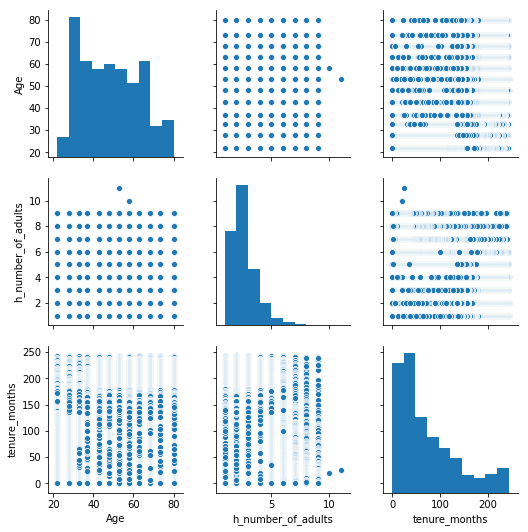

In [87]:
sns.pairplot(test_table[['Age','h_number_of_adults','tenure_months']])
plt.show()

In [88]:
test_table[['h_equivalised_income_value','h_number_of_children_in_hh']].corr()

,h_equivalised_income_value,h_number_of_children_in_hh
h_equivalised_income_value,1.000000,-0.170671
h_number_of_children_in_hh,-0.170671,1.000000


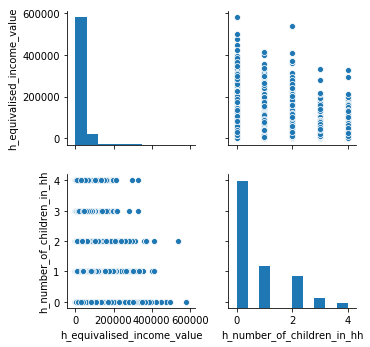

In [89]:
sns.pairplot(test_table[['h_equivalised_income_value','h_number_of_children_in_hh']])
plt.show()

In [90]:
categorical = [column for column in test_table.drop(columns=to_exclude).columns if column not in real_numeric]
categorical

['DTV_Active',
 'BB_Active',
 'Sports_Active',
 'Movies_Active',
 'MS_Active',
 'SGE_Active',
 'HD_Active',
 'Sky_Box_Sets_Active',
 'SkyKids_Active',
 'Handset_Active',
 'skyfibre_enabled',
 'h_residence_type',
 'h_presence_of_child_aged_0_4',
 'h_presence_of_child_aged_5_11',
 'h_presence_of_child_aged_12_17',
 'Up_Handset',
 'Up_Mobile',
 'BB_contract_status',
 'DTV_contract_status',
 'DTV_offer_status',
 'BB_offer_status']

In [91]:
cramer_analyzer = CramersV(test_table[categorical])

In [92]:
cramer_table=cramer_analyzer.produce_correlation_table()

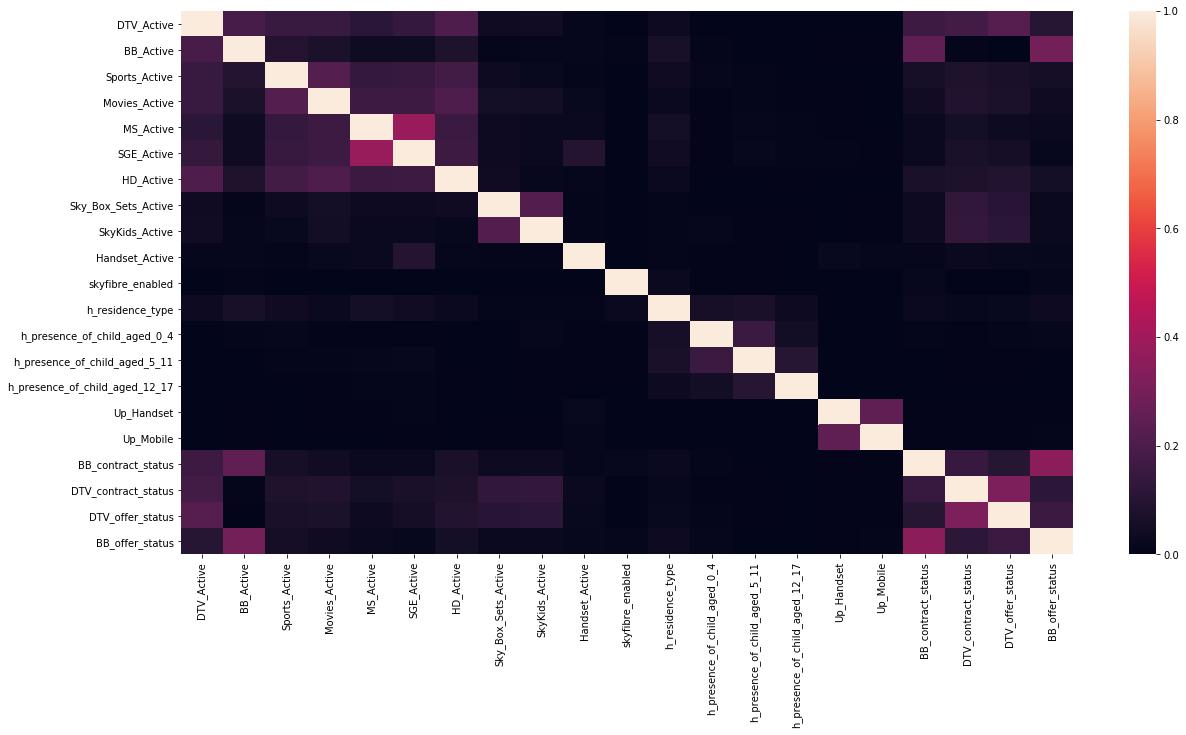

In [93]:
plt.figure(figsize=(20,10))
cramer_analyzer.produce_heatmap(cramer_table)

## Summer Cinema

In [94]:
to_analyze = campaigns_list[['campaign_program','campaign_name']].drop_duplicates()
idx=to_analyze[to_analyze.campaign_name=='Summer Cinema'].index
to_analyze.loc[idx,['campaign_program','campaign_name']]

,campaign_program,campaign_name
21951,skyOptimusGetMore,Summer Cinema


In [95]:
granularity_level_table,analysis_level = create_right_granularity_level(campaigns_list,to_analyze.loc[idx,['campaign_program','campaign_name']], granularity_level)
prop_mart_date = create_prop_mart_date(granularity_level_table)
granularity_level_table
subset_row = granularity_level_table.loc[0,:]
target_var_list = provide_target_flag(subset_row)

In [96]:
test_table = pull_table(CAMPAIGN_DATA_PATHS, PROP_MART_DATA_PATHS, subset_row,target_var_list,analysis_level,
                        OPTIMUS_COLS, PROPMART_FEAT,
                        base_date_label, prop_mart_date,subset_row['start_date'],
                        '=', control_name_dict[subset_row['campaign_program']], subset_row['product'],default_treat_table_name,
                        BUCKET_ID)

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [97]:
test_table.head()

,Base_Dt,account_number,TAs_in_last_14d,BB_Curr_Contract_Intended_End_Dt,DTV_Curr_Contract_Intnd_End_Dt,Curr_Offer_Intended_end_Dt_DTV,Curr_Offer_Intended_end_Dt_BB,BB_Last_Activation_Dt,DTV_Last_Activation_Dt,DTV_Active,...,ESports_Sports_Pref,GAA_Sports_Pref,Motorsport_Sports_Pref,Cycling_Sports_Pref,Netball_Sports_Pref,Up_Handset,Up_Mobile,L2_Campaign,ncomms,target
0,2019-06-30,621726380226,0,NaN,NaN,2019-10-19,NaN,2017-06-12,2012-03-19,1,...,0,0,0,0,0,0,0,Summer Cinema,3,0
1,2019-06-30,623136309183,0,NaN,NaN,NaN,2019-07-30,2018-01-30,2017-11-14,1,...,0,0,0,0,0,0,0,Summer Cinema,0,0
2,2019-06-30,630204471985,0,NaN,NaN,NaN,2019-10-18,2015-12-24,2015-12-18,1,...,0,0,0,0,0,0,0,Summer Cinema,0,0
3,2019-06-30,621065665906,0,2020-10-11,NaN,2020-05-13,2020-10-11,2017-11-27,2011-02-11,1,...,0,0,0,0,0,0,0,Summer Cinema,1,0
4,2019-06-30,623216340595,0,2020-07-24,NaN,2020-08-25,2020-07-24,2018-01-25,2018-02-02,1,...,0,0,0,0,0,0,0,Summer Cinema,2,0


In [98]:
test_table.shape

(760466, 56)

In [99]:
logger = create_logger()
_ = preprocess_data(test_table,mapping_dict,to_exclude,logger=logger)

08-Nov-19 13:24:28 - #################### DATA PREPROCESSING ####################
08-Nov-19 13:24:28 - 1) Removing features with high percentage of nulls
08-Nov-19 13:24:29 - 1a) Setting boolean input features to integers
08-Nov-19 13:24:29 - 1b) Removing constant features
08-Nov-19 13:24:33 - Removing ['Sky_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share']
08-Nov-19 13:24:33 - 2) Features engineering
08-Nov-19 13:24:33 - 2a) Mappings
08-Nov-19 13:24:33 - 2b) Rounding income value
08-Nov-19 13:24:33 - 2c) Creating contract/offer status features
08-Nov-19 13:25:02 - 2d) Creating number of days of tenure
08-Nov-19 13:25:18 -      Number of rows lost: 82792
08-Nov-19 13:25:18 -      % of rows lost: 10.89%
08-Nov-19 13:25:18 - Data preprocessed in 49.939 seconds


In [100]:
test_table.shape

(677674, 52)

In [101]:
numeric = test_table.drop(columns=to_exclude)._get_numeric_data().columns
for column in numeric:
    if is_binary(test_table[column], allow_na=False):
        print(column)

DTV_Active
BB_Active
Sports_Active
Movies_Active
MS_Active
SGE_Active
HD_Active
Sky_Box_Sets_Active
UOD_Active
SkyKids_Active
Handset_Active
h_presence_of_child_aged_0_4
h_presence_of_child_aged_5_11
h_presence_of_child_aged_12_17
BT_Consumer_Market_Share
Darts_Sports_Pref
Tennis_Sports_Pref
Racing_Sports_Pref
Golf_Sports_Pref
NFL_Sports_Pref
Wrestling_Sports_Pref
ESports_Sports_Pref
GAA_Sports_Pref
Motorsport_Sports_Pref
Cycling_Sports_Pref
Netball_Sports_Pref
Up_Handset
Up_Mobile


In [102]:
binary = ['DTV_Active', 'BB_Active', 'Sports_Active', 'Movies_Active', 'MS_Active' ,'SGE_Active', 'HD_Active', 'Sky_Box_Sets_Active', 'UOD_Active', 'SkyKids_Active',
          'Handset_Active', 'h_presence_of_child_aged_0_4', 'h_presence_of_child_aged_5_11', 'h_presence_of_child_aged_12_17', 'Up_Handset', 'Up_Mobile']

In [103]:
real_numeric = [feature for feature in numeric if feature not in binary]

In [104]:
analyzer = VarClusHi(test_table[real_numeric],maxeigval2=1,maxclus=None)

In [105]:
analyzer.varclus()

In [106]:
analyzer.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,F1_Sports_Pref,0.225665,0.020942,0.790898
1,0,Darts_Sports_Pref,0.381258,0.008864,0.624275
2,0,Tennis_Sports_Pref,0.337571,0.042652,0.691941
3,0,Boxing_Sports_Pref,0.445424,0.041532,0.578607
4,0,Wrestling_Sports_Pref,0.158282,0.009935,0.850164
5,1,ESports_Sports_Pref,0.506477,0.027616,0.507539
6,1,Motorsport_Sports_Pref,0.304090,0.041946,0.726379
7,1,Netball_Sports_Pref,0.551453,0.046030,0.470190
8,2,h_number_of_adults,0.112680,0.008630,0.895045
9,2,ncomms,0.523214,0.008228,0.480742


Cluster 2 and 4 are the really interesting ones

In [115]:
test_table[['Age','h_number_of_adults','tenure_months','ncomms']].corr()

,Age,h_number_of_adults,tenure_months,ncomms
Age,1.000000,0.138731,0.121975,-0.000999
h_number_of_adults,0.138731,1.000000,0.061597,-0.029284
tenure_months,0.121975,0.061597,1.000000,-0.180373
ncomms,-0.000999,-0.029284,-0.180373,1.000000


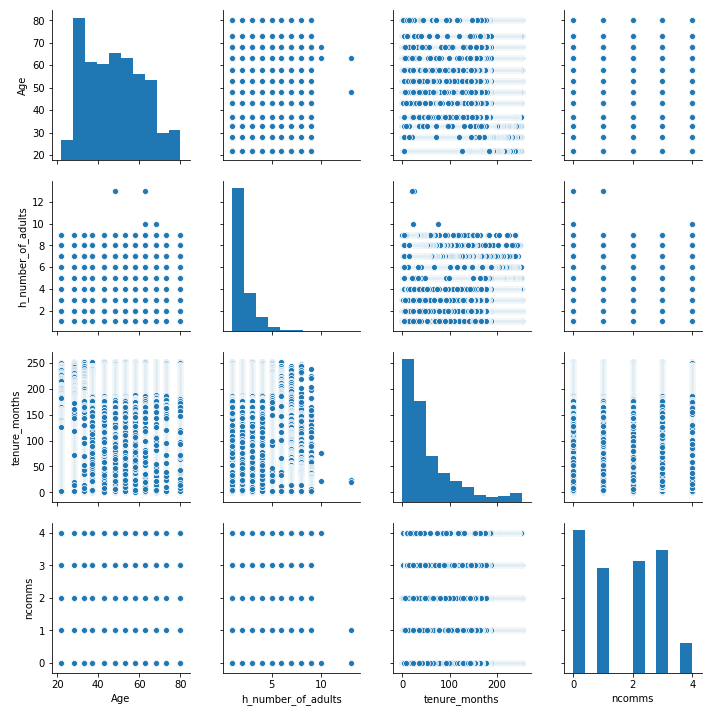

In [116]:
sns.pairplot(test_table[['Age','h_number_of_adults','tenure_months','ncomms']])
plt.show()

In [109]:
test_table[['h_equivalised_income_value','h_number_of_children_in_hh']].corr()

,h_equivalised_income_value,h_number_of_children_in_hh
h_equivalised_income_value,1.00000,-0.17744
h_number_of_children_in_hh,-0.17744,1.00000


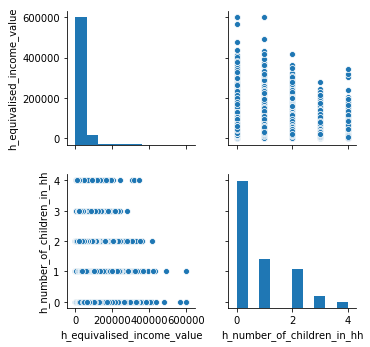

In [110]:
sns.pairplot(test_table[['h_equivalised_income_value','h_number_of_children_in_hh']])
plt.show()

In [111]:
categorical = [column for column in test_table.drop(columns=to_exclude).columns if column not in real_numeric]
categorical

['DTV_Active',
 'BB_Active',
 'Sports_Active',
 'Movies_Active',
 'MS_Active',
 'SGE_Active',
 'HD_Active',
 'Sky_Box_Sets_Active',
 'UOD_Active',
 'SkyKids_Active',
 'Handset_Active',
 'skyfibre_enabled',
 'h_residence_type',
 'h_presence_of_child_aged_0_4',
 'h_presence_of_child_aged_5_11',
 'h_presence_of_child_aged_12_17',
 'Up_Handset',
 'Up_Mobile',
 'BB_contract_status',
 'DTV_contract_status',
 'DTV_offer_status',
 'BB_offer_status']

In [112]:
cramer_analyzer = CramersV(test_table[categorical])

In [113]:
cramer_table=cramer_analyzer.produce_correlation_table()

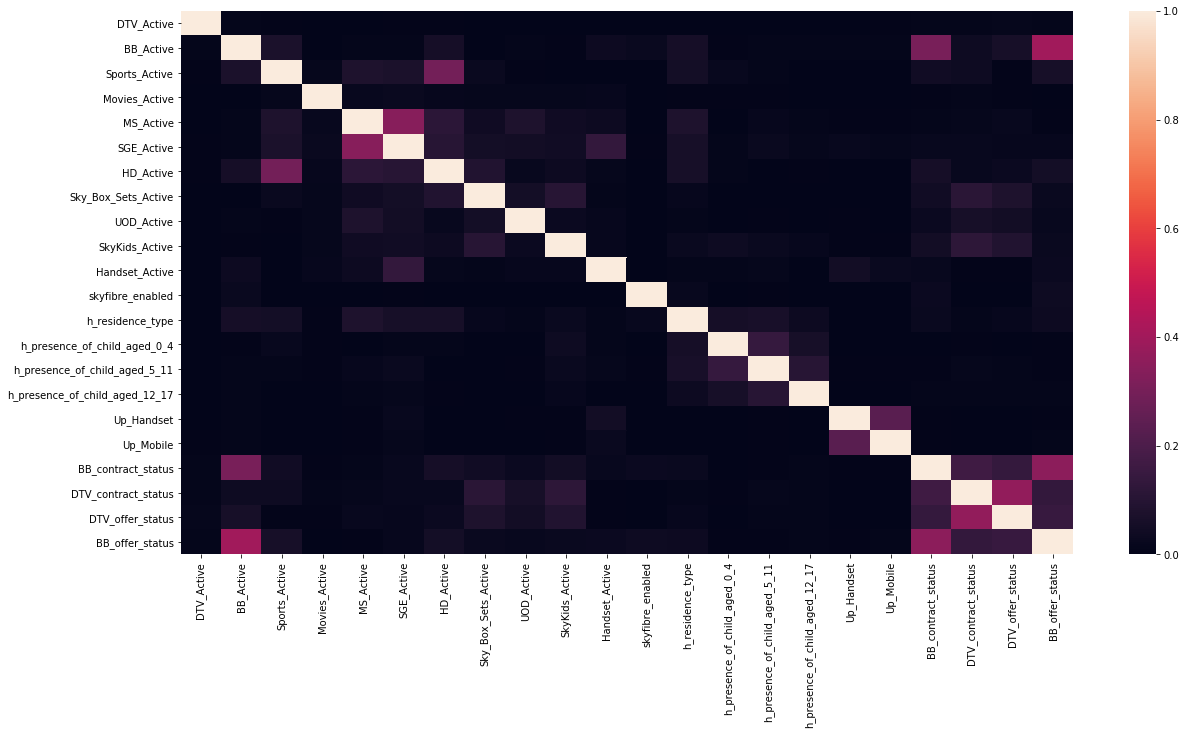

In [114]:
plt.figure(figsize=(20,10))
cramer_analyzer.produce_heatmap(cramer_table)

In [120]:
cramer_table[['BB_contract_status', 'DTV_contract_status']]

,BB_contract_status,DTV_contract_status
DTV_Active,0.008341,0.008055
BB_Active,0.308339,0.038340
Sports_Active,0.046288,0.035888
Movies_Active,0.005078,0.008999
MS_Active,0.011365,0.012765
SGE_Active,0.021944,0.022896
HD_Active,0.054762,0.022453
Sky_Box_Sets_Active,0.045223,0.111292
UOD_Active,0.029594,0.061181
SkyKids_Active,0.049242,0.117784
